In [1]:
import numpy as np
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
import math
import os
import sympy as sp
import random

%matplotlib inline

with open("calib/calib_data.json","r") as f:
    j = json.load(f)
j["cameraData"][0][1]
rgb_data=j["cameraData"][1][1]
left_data=j["cameraData"][2][1]
right_data=j["cameraData"][0][1]

directory=2

left_movie = cv2.VideoCapture(f'movie/{directory}/left.mp4')
right_movie = cv2.VideoCapture(f'movie/{directory}/right.mp4')
rgb_movie = cv2.VideoCapture(f'movie/{directory}/rgb.mp4')
disparity = cv2.VideoCapture(f'movie/{directory}/disparity.mp4')
confmap = cv2.VideoCapture(f'movie/{directory}/conf.mp4')

left_movie.get(cv2.CAP_PROP_FPS),rgb_movie.get(cv2.CAP_PROP_FPS)

(30.00029977240357, 30.00029977240357)

In [2]:
bl = 75 #mm base line
rcx = right_data["intrinsicMatrix"][0][2]
rcy = right_data["intrinsicMatrix"][1][2]
rfx = right_data["intrinsicMatrix"][0][0]
rfy = right_data["intrinsicMatrix"][1][1]

lcx = left_data["intrinsicMatrix"][0][2]
lcy = left_data["intrinsicMatrix"][1][2]
lfx = left_data["intrinsicMatrix"][0][0]
lfy = left_data["intrinsicMatrix"][1][1]

rgb_cx=rgb_data["intrinsicMatrix"][0][2]
rgb_cy=rgb_data["intrinsicMatrix"][1][2]
rgb_fx=rgb_data["intrinsicMatrix"][0][0]
rgb_fy=rgb_data["intrinsicMatrix"][1][1]
lfx

863.1793212890625

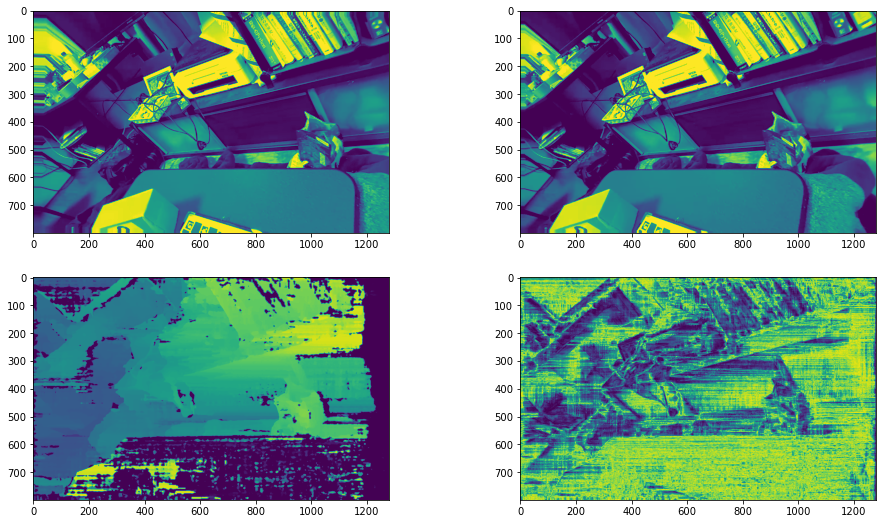

In [3]:
def getframes(frame_num,display=False):
    left_movie.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
    right_movie.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
    disparity.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
    confmap.set(cv2.CAP_PROP_POS_FRAMES,frame_num)

    
    left_ret, left_frame = left_movie.read()
    right_ret, right_frame = right_movie.read()

    dis_ret,dis_frame = disparity.read()
    conf_ret,conf_frame = confmap.read()


    left_frame =cv2.cvtColor(left_frame, cv2.COLOR_BGR2GRAY)
    right_frame =cv2.cvtColor(right_frame, cv2.COLOR_BGR2GRAY)
    dis_frame = cv2.cvtColor(dis_frame,cv2.COLOR_BGR2GRAY)
    conf_frame = cv2.cvtColor(conf_frame,cv2.COLOR_BGR2GRAY)

    
    if display:
        plt.figure(figsize=(16,9))
        plt.subplot(221).imshow(left_frame,vmin=0, vmax=255)
        plt.subplot(222).imshow(right_frame,vmin=0, vmax=255)
        plt.subplot(223).imshow(dis_frame)
        plt.subplot(224).imshow(conf_frame)
        plt.show()
    return left_frame,right_frame,dis_frame,conf_frame


left_frame,right_frame,dis_frame,conf_frame =getframes(100,display=True)

519 matches found


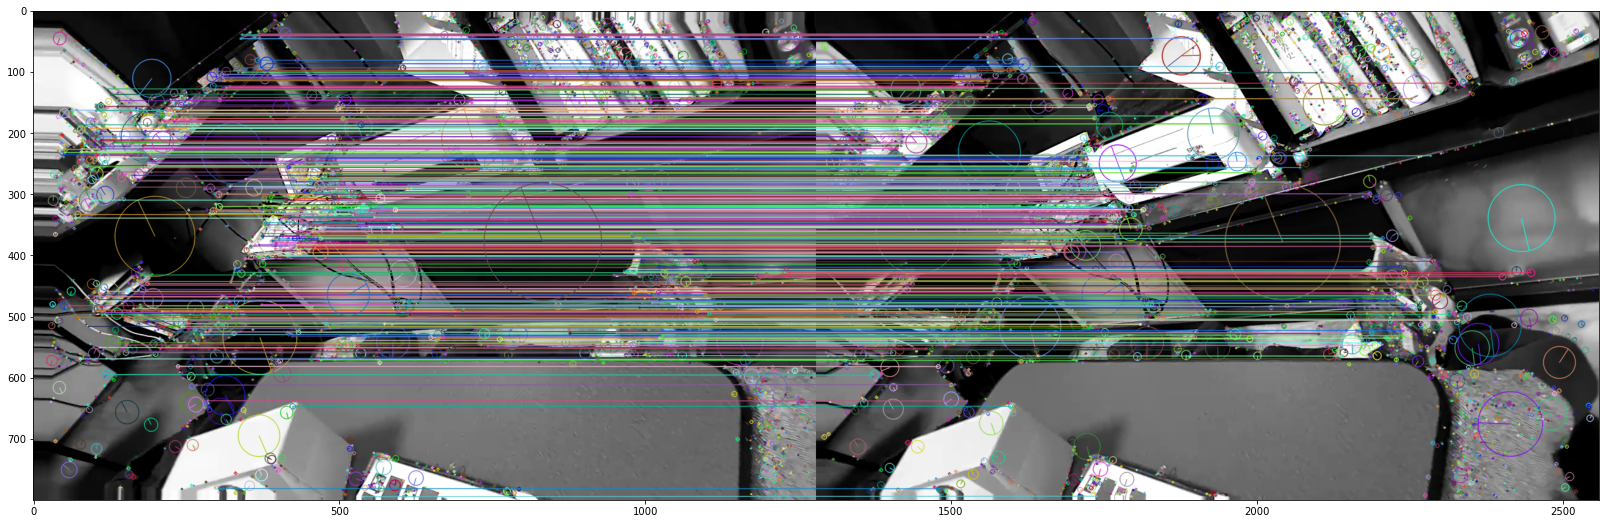

In [4]:
def feature_compute(left_frame,right_frame,feature_detection="SIFT",display=False):
    if feature_detection == "SIFT":
        feature=cv2.SIFT_create()
    elif feature_detection == "AKAZE":
         feature=cv2.AKAZE_create() 
    elif feature_detection == "ORB":
         feature=cv2.ORB_create()
    feature_left_kp, feature_left_des = feature.detectAndCompute(left_frame, None)
    feature_right_kp, feature_right_des = feature.detectAndCompute(right_frame, None)
    feature_bf = cv2.BFMatcher(crossCheck=True)
    feature_matches = feature_bf.match(feature_left_des, feature_right_des)

    feature_matches = [i for i in feature_matches if abs(feature_left_kp[i.queryIdx].pt[1]-feature_right_kp[i.trainIdx].pt[1])<1]
    print(len(feature_matches),"matches found")
    
    if display:
        img_feature = cv2.drawMatches(left_frame, feature_left_kp, right_frame , feature_right_kp, feature_matches, None, flags=4)
        plt.figure(figsize=(32,9))
        plt.imshow(img_feature)
        plt.show()
    return feature_left_kp, feature_left_des , feature_right_kp, feature_right_des , feature_matches

feature_left_kp, feature_left_des,feature_right_kp,feature_right_des,feature_matches=feature_compute(left_frame,
                                                                                                     right_frame,
                                                                                                     feature_detection="SIFT",
                                                                                                     display=True)

In [5]:
def feature_3d_position(feature_left_kp, feature_left_des,feature_right_kp, feature_right_des,feature_matches):
    positions = []
    right_descriptions = []
    right_kp = []
    for match in feature_matches:
        left_ind=match.queryIdx
        right_ind=match.trainIdx
        left_pt=feature_left_kp[left_ind].pt
        right_pt=feature_right_kp[right_ind].pt
        d = left_pt[0]-right_pt[0]
        if d < 1:
            pass
        else:
            z=rfx*bl/d
            x= (right_pt[0]-rcx)*bl/d
            y=(right_pt[1]-rcy)*bl/d
            position=[x,y,z]
            description =feature_right_des[right_ind]
            positions.append(position)
            right_descriptions.append(description)
            #! point!!
            right_kp.append(feature_right_kp[right_ind])
    positions = np.asarray(positions)
    right_descriptions=np.asarray(right_descriptions)
    right_kp=np.asarray(right_kp)
    return positions,right_descriptions,right_kp

In [6]:
positions,right_descriptions,right_kp=feature_3d_position(feature_left_kp,
                                                          feature_left_des,
                                                          feature_right_kp,
                                                          feature_right_des,
                                                          feature_matches)

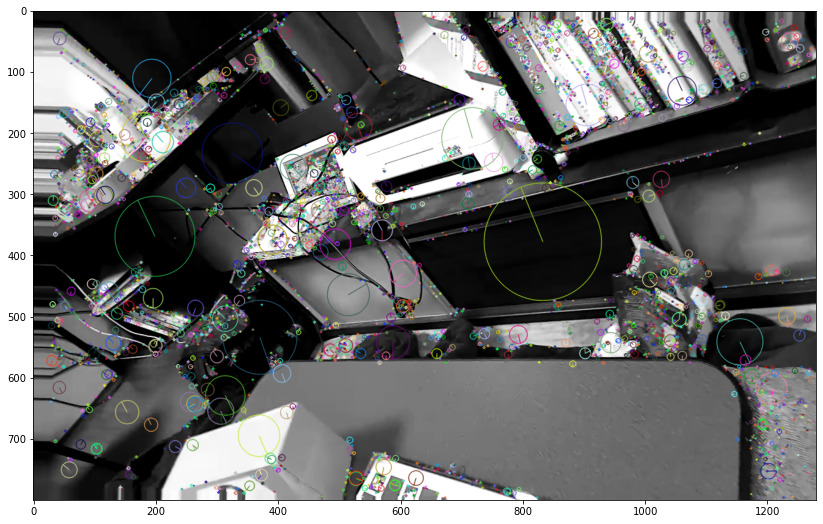

In [7]:
feature=cv2.SIFT_create()
kp, des = feature.detectAndCompute(left_frame, None)
img = cv2.drawKeypoints(left_frame,kp,None,flags=4)
plt.figure(figsize=(16,9))
plt.imshow(img)

In [58]:
def match_by_frame(t1_descriptions,t2_descriptions):
    bf = cv2.BFMatcher(crossCheck=True)
    matches = bf.match(t1_descriptions,t2_descriptions)
    good_matches = sorted(matches, key=lambda x: x.distance)
    return good_matches
matches = match_by_frame(des,right_descriptions)
len(matches)

519

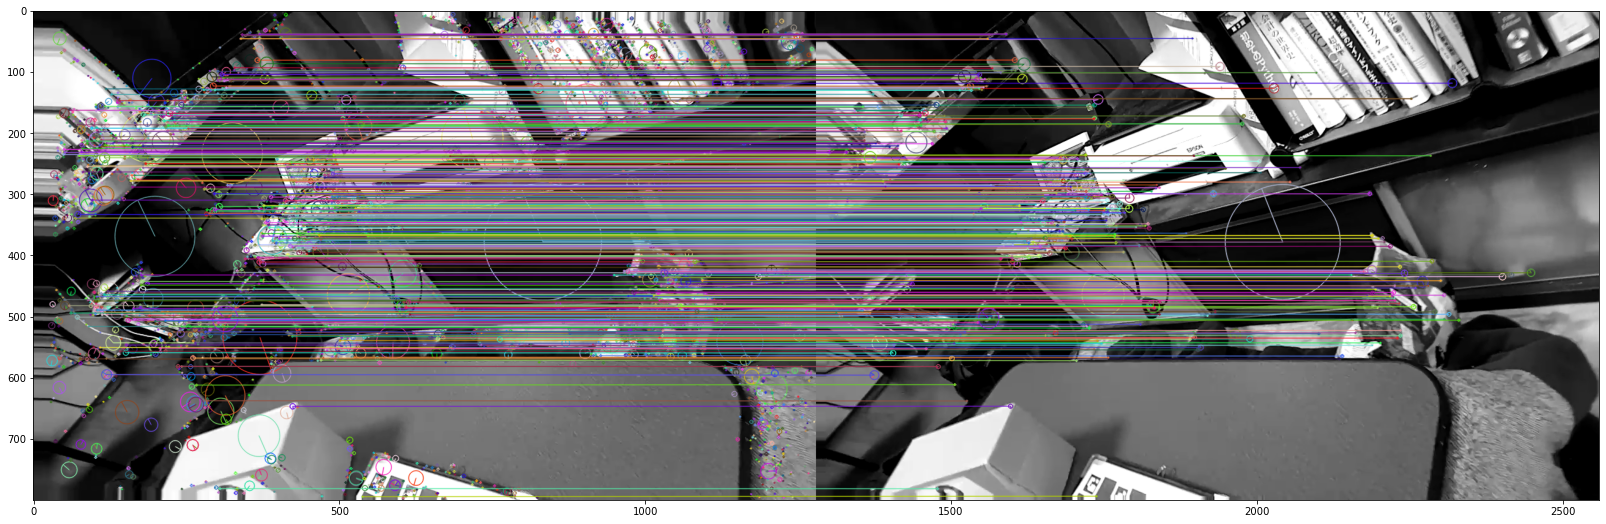

In [9]:
img = cv2.drawMatches(left_frame,kp,right_frame,right_kp,matches,None,flags=4)
plt.figure(figsize=(32,9))
plt.imshow(img)

In [66]:
def VPS(feature_3d_positions,keypoints,matches):
    MA = []
    for match in matches:
        X = feature_3d_positions[match.trainIdx]
        x = keypoints[match.queryIdx].pt
        axi = [-X[0],-X[1],-X[2],-1,0,0,0,0,x[0]*X[0],x[0]*X[1],x[0]*X[2],x[0]]
        ayi = [0,0,0,0,-X[0],-X[1],-X[2],-1,x[1]*X[0],x[1]*X[1],x[1]*X[2],x[1]]
        MA.append(axi)
        MA.append(ayi)
    MA = np.asarray(MA)
    MA = np.asarray(MA)
    U, s, V = np.linalg.svd(MA, full_matrices=False)
    ind = np.argmin(s)
    p = V[ind]
    P =p.reshape([3,4])

    h = P[:,3:]
    H = P[:,:3]
    X0 = - np.linalg.inv(H)@h
    rt,kinv = np.linalg.qr(np.linalg.inv(H))
    rpi = np.array([[-1,0,0],
                   [0,-1,0],
                   [0,0,1]])
    R = rt.T@rpi
    k = np.linalg.inv(kinv)
    internal = (k/k[2][2])@np.array([[-1,0,0],[0,-1,0],[0,0,1]])
    return X0,R,internal

VPS(positions,kp,matches)
    

(array([[-75.24131535],
        [ -0.82583595],
        [ -0.70078852]]),
 array([[ 9.99999947e-01, -3.22871456e-04,  4.90437780e-05],
        [ 3.22826797e-04,  9.99999536e-01,  9.07884947e-04],
        [-4.93368854e-05, -9.07869066e-04,  9.99999587e-01]]),
 array([[8.51206593e+02, 1.30515871e-01, 6.43451559e+02],
        [0.00000000e+00, 8.50200748e+02, 4.05592570e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]))

In [48]:
sample_matches = np.random.choice(matches,500)
MA=[]
for m in sample_matches:
    X = positions[m.trainIdx]
    x = kp[m.queryIdx].pt
    axi = [-X[0],-X[1],-X[2],-1,0,0,0,0,x[0]*X[0],x[0]*X[1],x[0]*X[2],x[0]]
    ayi = [0,0,0,0,-X[0],-X[1],-X[2],-1,x[1]*X[0],x[1]*X[1],x[1]*X[2],x[1]]
    MA.append(axi)
    MA.append(ayi)
MA = np.asarray(MA)
U, s, V = np.linalg.svd(MA, full_matrices=False)
ind = np.argmin(s)
p = V[ind]
P =p.reshape([3,4])

h = P[:,3:]
H = P[:,:3]
X0 = - np.linalg.inv(H)@h


rt,kinv = np.linalg.qr(np.linalg.inv(H))

X0,rt,kinv

(array([[-75.14677135],
        [ -0.76041557],
        [ -1.04863659]]),
 array([[-9.99999958e-01, -2.70968998e-04, -9.90436419e-05],
        [ 2.70872663e-04, -9.99999492e-01,  9.71373176e-04],
        [-9.93068035e-05,  9.71346307e-04,  9.99999523e-01]]),
 array([[ 7.59631498e+01, -6.97203289e-03, -4.88724604e+04],
        [ 0.00000000e+00,  7.60606472e+01, -3.08537765e+04],
        [ 0.00000000e+00,  0.00000000e+00, -6.46823571e+04]]))

In [26]:
im = np.array(left_data["intrinsicMatrix"])
np.linalg.inv(im)@H

array([[ 1.52574303e-05, -3.00953065e-09,  3.09394616e-07],
       [ 4.58511780e-10,  1.52452162e-05, -5.82907237e-08],
       [-2.01621847e-09,  1.46796287e-08,  1.54660315e-05]])

In [55]:
k = np.linalg.inv(kinv)
(k/k[2][2])@np.array([[-1,0,0],[0,-1,0],[0,0,1]])

array([[8.51496512e+02, 7.80516851e-02, 6.43407872e+02],
       [0.00000000e+00, 8.50405032e+02, 4.05647042e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [51]:
im

array([[863.17932129,   0.        , 626.25640869],
       [  0.        , 862.84960938, 407.80532837],
       [  0.        ,   0.        ,   1.        ]])

In [56]:
rt.T@np.array([[-1,0,0],[0,-1,0],[0,0,1]])

array([[ 9.99999958e-01, -2.70872663e-04, -9.93068035e-05],
       [ 2.70968998e-04,  9.99999492e-01,  9.71346307e-04],
       [ 9.90436419e-05, -9.71373176e-04,  9.99999523e-01]])

In [293]:
left_data["intrinsicMatrix"]

[[863.1793212890625, 0.0, 626.2564086914062],
 [0.0, 862.849609375, 407.8053283691406],
 [0.0, 0.0, 1.0]]

In [317]:
cip = np.array([[lfx,0,lcx],
                [0,lfy,lcy],
                [0,0,1]])
inv_cip = np.linalg.inv(cip)


for i in range(100):
    inds = [random.randint(0,70),random.randint(0,70),random.randint(0,70)]
    X1 = np.asarray(positions[matches[inds[0]].trainIdx])
    x1 = inv_cip@np.array([kp[matches[inds[0]].queryIdx].pt[0],
                            kp[matches[inds[0]].queryIdx].pt[1],
                                              1              ])
    n1 = x1/np.linalg.norm(x1)

#     print(X1)
#     print(f"cx : {lcx}  cy :{lcy}")
#     print("keypoint : ",kp[matches[inds[0]].queryIdx].pt)
#     print("norm : ", n1)

    X2 =np.asarray(positions[matches[inds[1]].trainIdx])
    x2 = inv_cip@np.array([kp[matches[inds[1]].queryIdx].pt[0],
                            kp[matches[inds[1]].queryIdx].pt[1],
                                              1              ])
    n2 = x2/np.linalg.norm(x2)


    X3 =np.asarray( positions[matches[inds[2]].trainIdx])
    x3 = inv_cip@np.array([kp[matches[inds[2]].queryIdx].pt[0],
                            kp[matches[inds[2]].queryIdx].pt[1],
                                              1              ])
    n3 = x3/np.linalg.norm(x3)


    cos12 = np.inner(n1,n2)
    cos23 = np.inner(n2,n3)
    cos31 = np.inner(n3,n1)

    L12 = np.linalg.norm(X1-X2)
    L23 = np.linalg.norm(X2-X3)
    L31 = np.linalg.norm(X3-X1)

    a = L23
    b = L31
    c = L12

    cosa = cos23
    cosb = cos31
    cosc = cos12

    A4 = ((a**2-c**2)/b**2-1)**2-4*c**2/b**2*cosa**2
    A3 = 4*((a**2-c**2)/b**2*(1-(a**2-c**2)/b**2)*cosb
            -(1-(a**2+c**2)/b**2)*cosa*cosc
            +2*c**2/b**2*cosa**2*cosb)
    A2 = 2*(((a**2-c**2)/b**2)**2 - 1
           + 2*((a**2-c**2)/b**2)**2*cosb**2
           + 2*(b**2-c**2)/b**2*cosa**2
           - 4*(a**2+c**2)/b**2*cosa*cosb*cosc 
           + 2*(b**2-a**2)/b**2*cosc**2)
    A1 = 4*(-(a**2-c**2)/b**2*(1+(a**2-c**2)/b**2)*cosb
            + 2*a**2/b**2*cosc**2*cosb
            - (1-(a**2+c**2)/b**2)*cosa*cosc)
    A0 = (1+(a**2-c**2)/b**2)**2 - 4*a**2/b**2*cosc**2

    print()
    if not np.isnan(A4):
        v = np.roots([A4,A3,A2,A1,A0])
        for vi in v:
            if vi.real == vi:
                vi = vi.real
                L1 = math.sqrt(b**2/(1+vi**2-2*vi*cosb))
                L3 = vi*L1
                L2 = L3*cosa + math.sqrt(L3**2*cosa**2 - (L3**2-a**2))

                X01 = n1*L1
                X02 = n2*L2
                X03 = n3*L3
                t1_3d_points=np.asarray([X1,X2,X3])
                t2_3d_points=np.asarray([X01,X02,X03])
                Y0 =np.mean(t1_3d_points,axis=0)
                X0 =np.mean(t2_3d_points,axis=0)
                H = (t1_3d_points-Y0).T@(t2_3d_points-X0)
                U, s, V = np.linalg.svd(H, full_matrices=False)
                R=U@V
                T=Y0-R@X0
                
                print()

                real = np.array([-7.5,0,0])
                pred = R@np.array([0,0,0])+T
                print(pred)
#                 if np.linalg.norm(real-pred) < 3:
#                     print("guessing it is in ")
#                     print(pred)





[-595.51426484 -551.3119269  2027.23982861]

[-101.96195555 1271.03958489 1447.2701184 ]


[-667.84729045 -679.4852979  -193.36084404]

[-357.82369411   37.44200149 -169.4438616 ]


[-2410.95972302 -1684.34486329  1835.38913315]

[-429.52311736 -651.96179184 3242.46451284]


[-592.49277134 1402.74209632 1158.70273251]

[-253.81833636  180.83944464  262.53605734]


[ 417.3896864  -479.51991713 1362.49780826]

[-1255.54948567    59.21823575  1936.80615624]


[-531.50072124   25.55963206  196.83095167]

[-87.69006785 -20.5818469  182.09684988]


[-559.47530327 1178.49740424 1170.95221003]

[ 41.08178073 741.35914226 823.2825999 ]


[-100.9254136  -127.97311736   64.54807203]

[-1291.56737812 -1395.43658464   162.79574589]


[-415.0446023   167.92546218 1117.14887957]

[ 860.89150493  958.73413487 1725.9060324 ]


[-249.44401749 -164.35860355  102.03533391]

[-91.25105501 158.49629805 154.7213527 ]


[-1282.09908785  -644.05401368  3680.43742889]

[-2038.63201629   277.50930181  3286.534

In [1467]:
X0,n1,X01

(array([ -5.86296064,  -6.1767723 , 136.18988497]),
 array([-0.25273399, -0.05972142,  0.96569088]),
 array([-46.85783807, -11.07257804, 179.0427459 ]))

In [1240]:
np.insert(n1,3,1)

array([-0.41720426, -0.26791626,  0.86842471,  1.        ])



https://ja.wikipedia.org/wiki/%E5%9B%9B%E6%AC%A1%E6%96%B9%E7%A8%8B%E5%BC%8F


In [11]:

sp.var('x, a, b, c, d, e')
Sol4=sp.solve (1*x**4+1*x**3+1*x**2+1*x+1, x)